In [1]:
import numpy as np
import os
import sys
import random
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from factor_vae import FactorVAEDSprites, Discriminator
from datasets import train_test_random_split, load_dsprites, CustomDataset
from train import train_factor_vae, test_factor_vae

In [2]:
dataset = load_dsprites("../datasets/dsprites.npz",False)
imgs = dataset["imgs"]

In [3]:
data_size = 1000
data = CustomDataset(imgs,data_size)

In [4]:
data_train, data_test = train_test_random_split(data, 0.8)

In [5]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False)

In [6]:
model = FactorVAEDSprites()
discriminator = Discriminator(nb_layers=4,hidden_dim=500)
vae_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
gamma = 0
epochs = 10

In [7]:
train_losses_list, recon_losses_list, kl_divs_list, tc_losses_list, discriminator_losses_list = train_factor_vae(model, discriminator, epochs, train_loader, vae_optimizer, discriminator_optimizer, gamma, 'bernoulli')

/Users/ireneburger/opt/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: 2605.119328425481, recon loss: 2605.087346003606, kl div: 0.031977589192907684, TC loss: 0.012102215819490643, discriminator loss: 0.6937832924035879
Epoch 1 finished, loss: 1156.0220477764424, recon loss: 1154.8040395883413, kl div: 1.2180055471567006, TC loss: -0.12661768639316925, discriminator loss: 0.6898347689555242
Epoch 2 finished, loss: 639.219482421875, recon loss: 632.8331064077524, kl div: 6.386375665664673, TC loss: 0.1104173889526954, discriminator loss: 0.6179297887361966
Epoch 3 finished, loss: 594.5719369741587, recon loss: 585.9134850135216, kl div: 8.658455005058876, TC loss: 0.4186434837488028, discriminator loss: 0.4918542504310608
Epoch 4 finished, loss: 578.6201970027043, recon loss: 571.5742703951322, kl div: 7.045930679027851, TC loss: 0.6290409450347607, discriminator loss: 0.4315101894048544
Epoch 5 finished, loss: 572.4422842172476, recon loss: 567.357173039363, kl div: 5.085107986743633, TC loss: 0.7262264490127563, discriminator los

In [8]:
def plot_loss(loss_list, title):
    plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training "+title)
    plt.show()

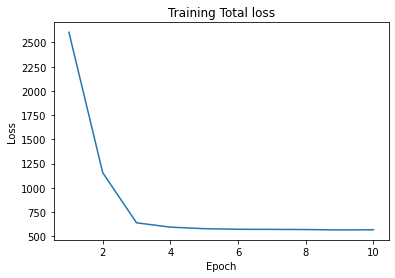

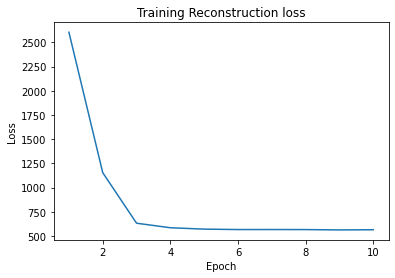

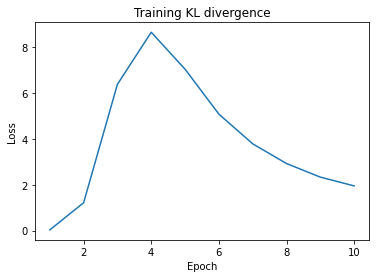

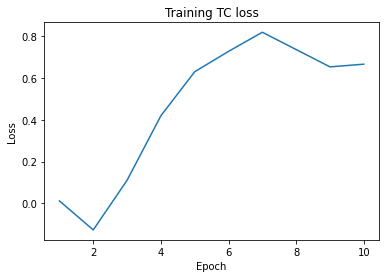

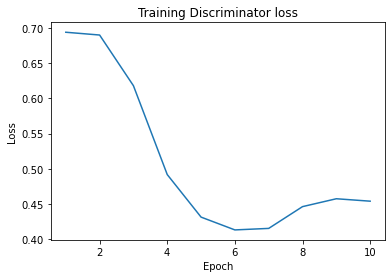

In [9]:
plot_loss(train_losses_list, "Total loss")
plot_loss(recon_losses_list, "Reconstruction loss")
plot_loss(kl_divs_list, "KL divergence")
plot_loss(tc_losses_list, "TC loss")
plot_loss(discriminator_losses_list, "Discriminator loss")

In [10]:
test_factor_vae(model, discriminator, test_loader, gamma, 'bernoulli')

Test loss: 563.7948913574219


/Users/ireneburger/opt/anaconda3/envs/atml/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


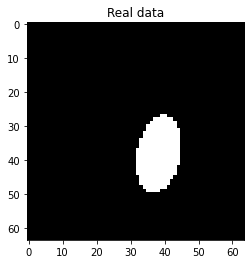

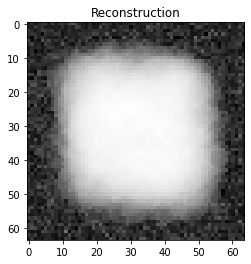

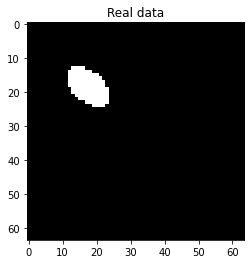

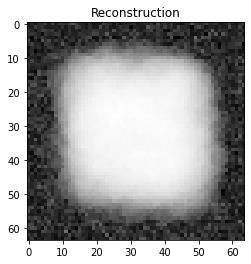

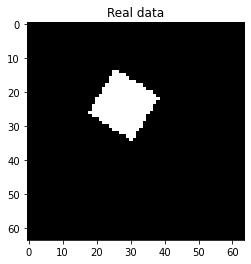

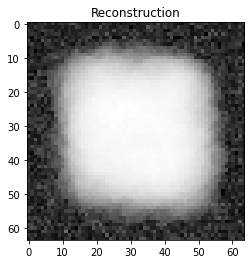

In [11]:
device = None
with torch.no_grad():
    for i in [1,2,20]:
        data, _ = data_test[i]
        data = data.float()
        if device != None:
            data = data.to(device)
        recon, mu, logvar, z = model(data)
        plt.imshow(data.cpu(), cmap='Greys_r')
        plt.title("Real data")
        plt.show()
        plt.imshow(recon.squeeze().cpu(), cmap='Greys_r')
        plt.title("Reconstruction")
        plt.show()

In [12]:
dataset.allow_pickle = True
latents_sizes = dataset['metadata'][()][b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1, fixed = None):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        if fixed == lat_i:
            fixed_value = np.random.randint(lat_size, size=1)
            samples[:, lat_i] = np.full(size, fixed_value)
        else:
            samples[:, lat_i] = np.random.randint(lat_size, size=size)
    return samples

In [ ]:
def compute_latent_variance(size):
    sample = sample_latent(size)
    imgs_sampled = imgs[latent_to_index(sample)]
    latents = []
    data_sampled = CustomDataset(imgs_sampled,size)
    loader = DataLoader(data_sampled, batch_size=64)
    for data,_ in loader:
        data = data.float()
        if device != None:
            data = data.to(device)
        recon, mu, logvar, z = model(data)
        z = list(z.detach().cpu().numpy())
        latents= latents+[list(l) for l in z]
    global_vars = np.var(latents, axis = 0) 
    return global_vars

latents_global_variance = compute_latent_variance(10000)
print(latents_global_variance)


In [ ]:
def FactorVAE_entanglement_metric(nb_samples,sample_size):
    loss = 0
    classification = np.zeros((len(latents_sizes),10))
    for i in range(nb_samples):
        k = np.random.randint(len(latents_sizes)-1)+1
        latents_sampled = sample_latent(size=sample_size, fixed=k)
        indices_sampled = latent_to_index(latents_sampled)
        imgs_sampled = imgs[indices_sampled]
        data_sampled = CustomDataset(imgs_sampled,sample_size)
        loader = DataLoader(data_sampled, batch_size=64)
        latents_rep = []
        for data, _ in loader:
            data = data.float()
            if device != None:
                data = data.to(device)
            recon, mu, logvar, z = model(data)
            z = list(z.detach().cpu().numpy())
            latents_rep= latents_rep+[list(l) for l in z]
        latents_var = np.var(latents_rep, axis = 0) 
        latents_var_normalized = np.divide(latents_var, latents_global_variance)
        idx = np.argmin(latents_var_normalized)
        classification[k,idx]+=1
    print(classification)
    for i in range(len(latents_sizes)):
        loss = loss + np.sum(classification[i])- np.max(classification[i])
    return loss/nb_samples

In [ ]:
FactorVAE_entanglement_metric(50,500)